In [1]:
import numpy as np
from PIL import Image
import scipy.stats as sps
import matplotlib.pyplot as plt

import cvxpy as cvx
import numpy.linalg as la

from tqdm import tqdm  

In [2]:
def getPics(files, colored = False, limits = None):
    pics = []
    if not colored:
        for file in files:
            pics.append(Image.open(file).convert("L"))
        matrix = list(map(lambda x: np.asarray(x), pics))
        if limits is not None:
            matrix = list(map(lambda m: m[limits[0]:limits[1], 
                                          limits[0]:limits[1]], matrix))
        pics_shape = matrix[0].shape
        matrix = list(map(lambda x: x.reshape(-1), matrix))
        return matrix, pics_shape
    
    if colored:
        for file in files:
            pics.append(Image.open(file))
        matrix = list(map(lambda x: np.asarray(x), pics))
        pics_shape = matrix[0].shape
        matrix = list(map(lambda x: x.reshape(-1), matrix))
        return matrix, pics_shape

In [3]:
def picCombiner(pics, alpha):
    return (np.array(pics).T @ alpha).T


def Display(image, shape, colored = True):
    if colored:
        plt.imshow(image.reshape(shape)/255, vmin=0.0, vmax=1.0)
    else:
        plt.imshow(image.reshape(shape)/255, vmin=0.0, vmax=1.0, cmap = 'gray')
    plt.show()
    
    
def DisplayMulti(images, shape, colored = True, disp = None):
    if disp == None:
        plt.figure(figsize=(12, 4))
    else:
        plt.figure(figsize=(disp[1]*4, disp[0]*4))
    if colored:
        for i, image in enumerate(images):
            if disp == None:
                disp = (1, len(images))
            plt.subplot(*disp, i + 1)
            plt.imshow(image.reshape(shape)/255, vmin=0.0, vmax=1.0)
    else:
        for i, image in enumerate(images):
            if disp == None:
                disp = (1, len(images))
            plt.subplot(*disp, i + 1)
            plt.imshow(image.reshape(shape)/255, vmin=0.0, vmax=1.0, cmap = 'gray')
    plt.show()
        
        
def getRandWeight(size):
    arr = sps.uniform.rvs(size=size)
    return arr/arr.sum()


def getMixture(matrixs, weights = None):
    if weights is None:
        weights = getRandWeight(len(matrixs))
    return picCombiner(np.array(matrixs), np.array(weights))


In [4]:
def LPSolver(r, C, d, extremum):
    alpha = cvx.Variable(C.shape[1])
    constraints = [ C @ alpha + d >= 0 ]
    optimiser = (cvx.Minimize if (extremum == 'min') else cvx.Maximize)
    obj = optimiser(r @ (C @ alpha + d))
    prob = cvx.Problem(obj, constraints=constraints)
    prob.solve()

    return prob.value, alpha.value


def preparation(X, N, tol=1e-6):
    inds = np.abs(X).sum(axis=1) > tol
    X_large = X[inds, :]
    
    d = X_large.mean(axis=1)
    
    U = X_large - d[:, np.newaxis]
    UU, _, _ = np.linalg.svd(X_large - d[:, np.newaxis], compute_uv=True)

    C = UU[:, :N - 1]
    
    return C, d, inds


def is_exp_pt(C, d, alpha, tol=1e-6):
    sin_value = np.linalg.svd(C[(np.abs(C @ alpha + d) < tol), :], compute_uv=False)
    sin_value = np.abs(sin_value)
    temp = sin_value / sin_value.sum()
    return np.sum(temp > tol) == C.shape[1]


def CAMNS_LP(X_, N, tol_lp=1e-6, tol_ext=1e-6, tol_zeros=1e-6, max_iter=10**9):
    C, d, inds = preparation(X_, N, tol_zeros)
    L, M_ = X_.shape
    X = X_[inds, :]
    
    LL = X.shape[0]
    
    B = np.eye(LL)
    S = np.empty(shape=(LL, 0))
    
    for i in range(max_iter):
        if  S.shape[1] >= N:
            break
            
        w = sps.norm.rvs(size=(LL))
        r = B @ w
        
        p, a1 = LPSolver(r, C, d, 'min')
        q, a2 = LPSolver(r, C, d, 'max')

        s1 = C @ a1 + d
        s2 = C @ a2 + d
                
        if S.shape[1] == 0:
            if is_exp_pt(C, d, a1, tol=tol_ext):
                S = np.hstack([S, s1[:, np.newaxis]])
            if is_exp_pt(C, d, a2, tol=tol_ext):
                S = np.hstack([S, s2[:, np.newaxis]])
        else:
            if np.abs(p) / (np.linalg.norm(r) * np.linalg.norm(s1)):
                if is_exp_pt(C, d, a1, tol=tol_ext):
                    S = np.hstack([S, s1[:, np.newaxis]])
            
            if np.abs(q) / (np.linalg.norm(r) * np.linalg.norm(s2)) >= tol_lp:
                if is_exp_pt(C, d, a2, tol=tol_ext):
                    S = np.hstack([S, s2[:, np.newaxis]])
            
        Q, _ = np.linalg.qr(S)
        B = np.eye(LL) - Q @ Q.T
        
    if S.shape[1] > N:
        slice_ = np.arange(N-1)
        slice_ = np.append(slice_, N-1 if (p > q) else N)
        S = S[:,slice_]
        
    res = np.zeros(shape=(L, N))
    res[inds, :] = S
    return res
    

In [5]:
def PrepareMix(matrixes, m = 10):
    mix_ = [getMixture(matrixes) for _ in range(m)]

    mix_ = np.array(mix_).T
    mix_.shape
    return mix_


def DisplayExperiment(bw_matrix, mix, res, bw_pics_shape):
    print("Before:")
    DisplayMulti(bw_matrix, bw_pics_shape, False)

    print("Part of mix:")
    DisplayMulti(mix.T[:len(bw_matrix)], bw_pics_shape, False)

    print("After:")
    DisplayMulti(res.T, bw_pics_shape, False)
    
    
def conduct(files, m=10, limits = None):
    matrixes, pics_shape = getPics(files, limits=limits)
    mix = PrepareMix(matrixes, m)
    res = CAMNS_LP(mix, len(matrixes))
    DisplayExperiment(matrixes, mix, res, pics_shape)


Необоходимые условия:

1. Все значения матрицы картинки > 0.
2. Для каждой кортинки существует значение в матрицы > 0, для которого соответсвующие значения в других картинках = 0.
3. Смешанная кортинка получается в результате взятия линеной комбинации картинок с суммой весов 1.
4. Кол-во спутанных картинок хотя бы кол-во картинок на входе, при

Before:


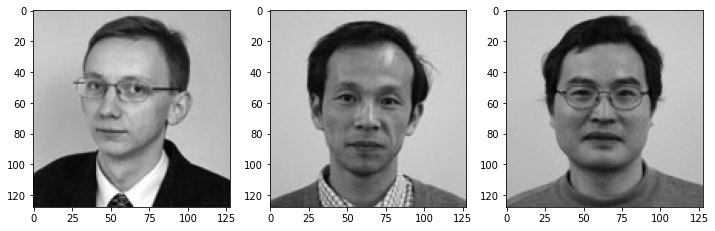

Part of mix:


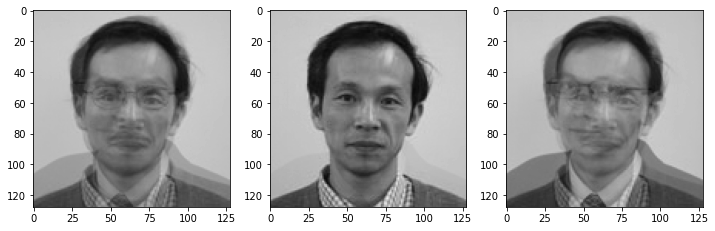

After:


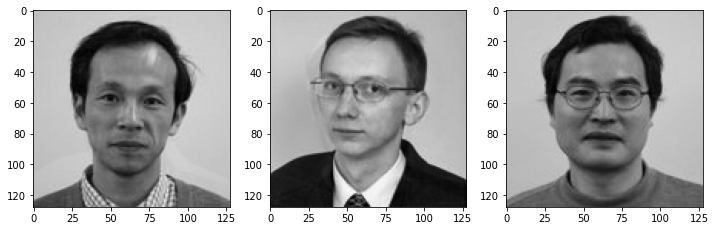

In [6]:
conduct(['pics/A.jpg', 'pics/B.jpg', 'pics/C.jpg'])

Наш алгоритм отработал правильно на картинке из примера. Проведем эксперимент: попробуем другие картинки.

Before:


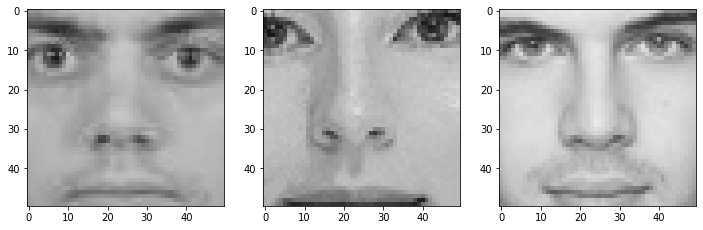

Part of mix:


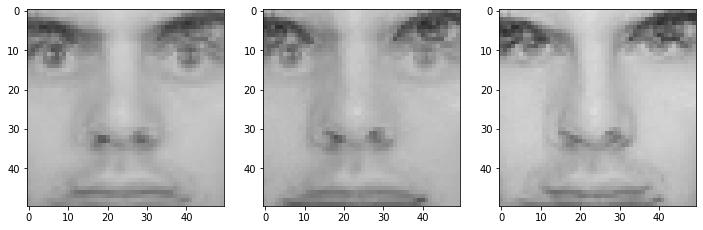

After:


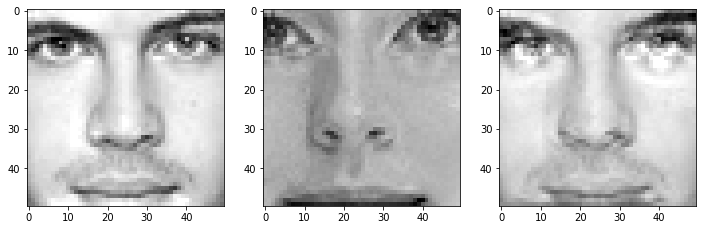

In [7]:
conduct(['pics/A.jpeg', 'pics/B.jpeg', 'pics/C.jpeg'], limits=(75, 125))

Мы видим, что для данных картинок исходные изображения были востановлены с искажением, хотя приблизительный их вид сохранился. Вероятно нарушаются условия из статьи (при которых алгоритм работает корректно). 

Рассмотрим еще один пример, с большим числом картинок.

Before:


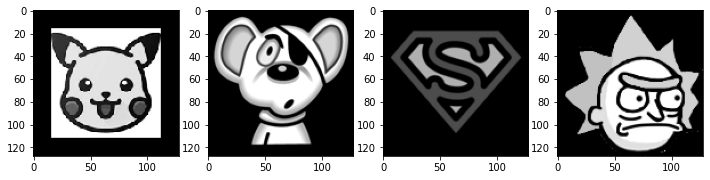

Part of mix:


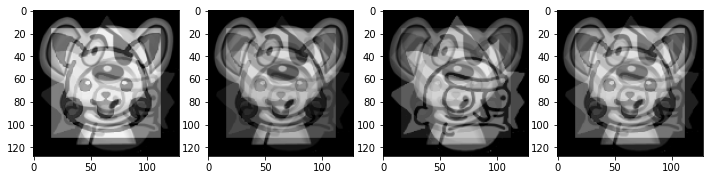

After:


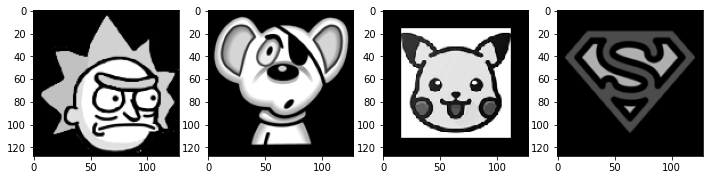

In [8]:
conduct(['pics/P1.png', 'pics/P2.png', 'pics/P3.png', 'pics/P4.png'])

Алгоритм отработал корректно.

Проверим, что произойдет, если мы умешим число смешанных картинок.

Before:


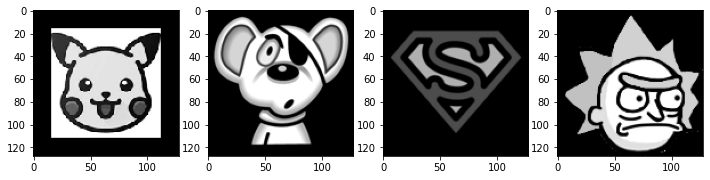

Part of mix:


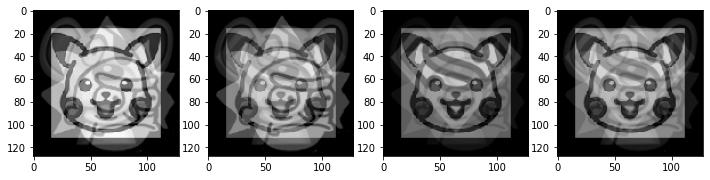

After:


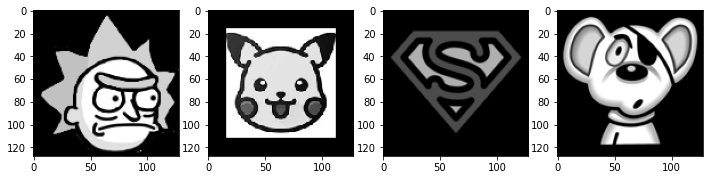

In [9]:
conduct(['pics/P1.png', 'pics/P2.png', 'pics/P3.png', 'pics/P4.png'], m=4)

Мы видим, что при кол-ве смешанных картинок равному, кол-ву исходных картинок так же правильно восстановились изображения.

Попробуем еще уменьшить число картинок.

Before:


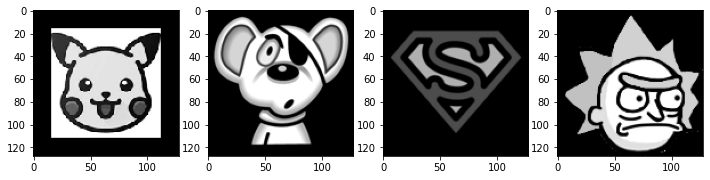

Part of mix:


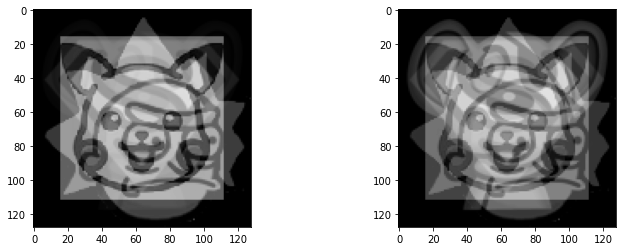

After:


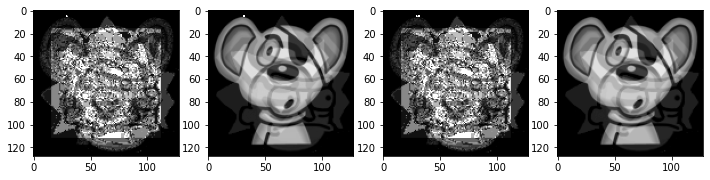

In [10]:
conduct(['pics/P1.png', 'pics/P2.png', 'pics/P3.png', 'pics/P4.png'], m=2)

Мы видим, что восстановить изображения не удалось (что было ожидаемо).

Теперь попробуем передать одно изображение дважды.

Before:


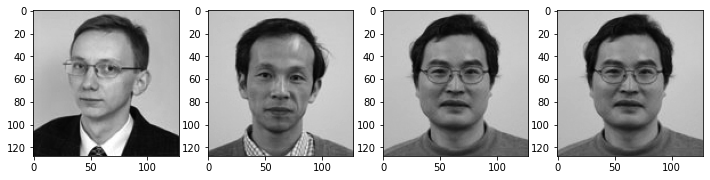

Part of mix:


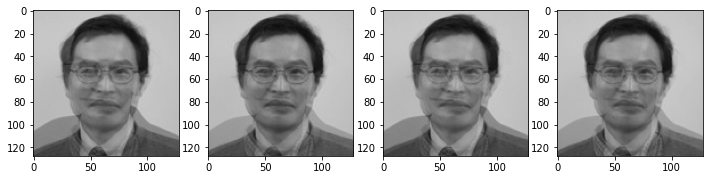

After:


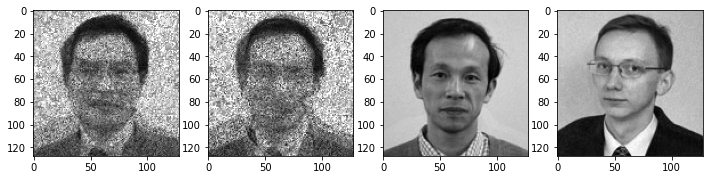

In [11]:
conduct(['pics/A.jpg', 'pics/B.jpg', 'pics/C.jpg', 'pics/C.jpg'])

Мы видим, что картинки восстановить не удалось, изображения исказились. Причем изображения переданные один раз распознались корректно.

Итог: мы видим, что не для всех картинок алгоритм работает корректно, в частности это может случиться если продублировать картинку. Так же важно передать достаточное число линейных комбинаций.